In [840]:
import xlrd
import sklearn
from sklearn.neural_network import MLPClassifier
import numpy as np
import os
import scipy.stats
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import load_model
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras import regularizers
from keras import backend as K
from keras import regularizers
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
import scipy.stats
import random
import tensorflow as tf
from collections import defaultdict
from scipy import stats
import matplotlib.pyplot as plt 
from keras import optimizers
import time

In [841]:
# open the excel file
loc = ("Premier_League_Data.xlsx")
wb = xlrd.open_workbook(loc)

In [842]:
num_parameters = 22
num_teams = 20
num_stats_sheets = 7
num_total_sheets = 13

In [843]:
# create the sheets

stats_sheets = []
for i in range(0, num_stats_sheets):
    stats_sheets.append(wb.sheet_by_index(i))

In [844]:
stats_by_season = []
teams_per_season = []
promoted_per_season = []
relegated_per_season = []

In [845]:
stats_this_year = {}
teams_this_year = []
promoted_this_year = []
relegated_this_year = []
for m in range(0, num_stats_sheets):
    for i in range(1, num_teams + 1):
        team = stats_sheets[m].cell_value(i, 0)
        teams_this_year.append(team)
        stats_this_year[team] = []
        for j in range(1, num_parameters + 1):
            stats_this_year[team].append(stats_sheets[m].cell_value(i, j))
            
    relegated_this_year.append(teams_this_year[num_teams - 3])
    relegated_this_year.append(teams_this_year[num_teams - 2])
    relegated_this_year.append(teams_this_year[num_teams - 1])

    promoted_this_year.append(stats_sheets[m].cell_value(num_teams + 3, 0))
    promoted_this_year.append(stats_sheets[m].cell_value(num_teams + 4, 0))
    promoted_this_year.append(stats_sheets[m].cell_value(num_teams + 5, 0))

    stats_by_season.append(stats_this_year)
    teams_per_season.append(teams_this_year)
    promoted_per_season.append(promoted_this_year)
    relegated_per_season.append(relegated_this_year)
    

In [846]:
# get promoted teams from 2010/11 (no other info on this sheet, so has to be hard-coded in)

stats_1011_sheet = wb.sheet_by_index(13)
title = stats_1011_sheet.cell_value(0, 0)
promoted_1011 = []
for i in range(1, 4):
    team = stats_1011_sheet.cell_value(i, 0)
    promoted_1011.append(team.strip())
promoted_per_season.append(promoted_1011)

In [847]:
score_sheets = []
for i in range(num_stats_sheets, num_total_sheets):
    score_sheets.append(wb.sheet_by_index(i))

# scores_1718_sheet = wb.sheet_by_index(7)
# scores_1617_sheet = wb.sheet_by_index(8)
# scores_1516_sheet = wb.sheet_by_index(9)
# scores_1415_sheet = wb.sheet_by_index(10)
# scores_1314_sheet = wb.sheet_by_index(11)
# scores_1213_sheet = wb.sheet_by_index(12)
# score_sheets = []
# score_sheets.append(scores_1718_sheet)
# score_sheets.append(scores_1617_sheet)
# score_sheets.append(scores_1516_sheet)
# score_sheets.append(scores_1415_sheet)
# score_sheets.append(scores_1314_sheet)
# score_sheets.append(scores_1213_sheet)


In [848]:
all_results = []
all_stats = []
all_outcomes = []
stats_pairs_by_season = []
outcomes_by_season = []

for i in range (0 , 6):
    results = {}
    for j in range (1, num_teams * (num_teams - 1) + 1):
        home_team = score_sheets[i].cell_value(j, 1).strip()
        away_team = score_sheets[i].cell_value(j, 2).strip()
        result = score_sheets[i].cell_value(j, 5)
        if result == "W":
            results[(home_team, away_team)] = 1
        elif result == "L":
            results[(home_team, away_team)] = -1
        else:
            results[(home_team, away_team)] = 0
    all_results.append(results)
    stats = []
    outcomes = []
    # print(i, len(results))  
    # print(i, len(all_results))
    counter = 0
    for key in results.keys():
        counter = counter + 1
        # each home-away pair for that season
        home_team = key[0].strip()
        away_team = key[1].strip()
        prev_season_stats = stats_by_season[i + 1]
        if home_team in prev_season_stats.keys():
            home_stats = prev_season_stats[home_team]
        else:
            promoted_index = promoted_per_season[i+1].index(home_team)
            promoted_team = promoted_per_season[i+2][promoted_index] # out of bounds error?
            home_stats = prev_season_stats[promoted_team]
        if away_team in prev_season_stats.keys():
            away_stats = prev_season_stats[away_team]
        else:
            promoted_index = promoted_per_season[i + 1].index(away_team)
            promoted_team = promoted_per_season[i + 2][promoted_index] # out of bounds error?
            away_stats = prev_season_stats[promoted_team]
        instance = []
        for k in range (0, len(home_stats)):
            #instance.append(home_stats[k])
            #instance.append(away_stats[k])
            if (away_stats[k] == 0):
                ratio = (home_stats[k] + 1) / (away_stats[k] + 1)
            else:
                ratio = home_stats[k] / away_stats[k]
            ratio = home_stats[k] - away_stats[k]
            instance.append(ratio)
        outcome = results[(home_team, away_team)]
        # print(home_team, away_team, ratio, outcome)
        if (outcome !=0):
            stats.append(instance)
            all_stats.append(instance)
            outcomes.append(outcome)
            all_outcomes.append(outcome)
    stats_pairs_by_season.append(stats)
    outcomes_by_season.append(outcomes)
print(len(all_stats))
# print(all_stats)
# print(all_outcomes)
print(len(all_outcomes))
              

1710
1710


In [849]:
num_classes = 2

x_train, x_test, y_train, y_test = train_test_split(all_stats, all_outcomes, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

# convert data into numpy arrays
# x_train = np.array(x_train)
# y_train = np.array(y_train)
# x_train = np.array(x_train)
# y_train = np.array(y_train)
# x_val = np.array(x_val)
# y_val = np.array(y_val)
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_val = keras.utils.to_categorical(y_val, num_classes)

num_records = 1457
# num_records = x_train.shape[0]
num_features = 22
# num_features = x_train.shape[1]


print("Training Feature matrix being passed into neural network has " + str(num_records) + 
      " vectors and " + str(num_features) + " parameters. ")

Training Feature matrix being passed into neural network has 1457 vectors and 22 parameters. 


In [850]:
def fit_maxent_classifier(X, y, testFeatureVectors): 
    mod = LogisticRegression(fit_intercept=True, multi_class = 'multinomial', solver = 'newton-cg')
    mod.fit(X, y)
    pred = mod.predict(testFeatureVectors)
    print(pred)
    return pred

In [851]:
pred = fit_maxent_classifier(x_train, y_train, x_val)

correct = 0
total = len(y_val)
for i in range(0, len(y_val)):
    if (y_val[i]==pred[i]):
        correct+=1
    else:
        if (y_val[i]==0):
            total = total - 1
            print(y_val[i])
        
print(correct)
print(total)
print(correct/total)


[-1 -1 -1 -1  1  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1 -1  1  1 -1  1 -1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1 -1 -1  1  1  1  1
  1 -1  1 -1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1 -1
 -1  1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1
  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1
 -1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1
  1 -1  1  1 -1  1  1  1 -1  1  1 -1  1  1  1  1  1 -1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1  1  1
  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1
  1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1 -1  1  1  1 -1 -1  1  1
  1  1 -1 -1  1 -1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1  1
  1  1 -1  1  1  1 -1  1  1 -1]
195
274
0.7116788321167883


In [852]:
def keras_nn_classifier(learning_rate):
    # create the model
    model = Sequential()
    
    # add the layers
    model.add(Dense(1000, input_dim = num_features, kernel_regularizer = regularizers.l2(0.1), activation = 'sigmoid')) # hidden layer
    # model.add(Dropout(0.5))
    # model.add(Dense(750, kernel_regularizer = regularizers.l2(0.01), activation = 'sigmoid')) # second hidden layer
    #model.add(Dropout(0.3))
    #model.add(Dense(300, activation = 'sigmoid')) # second hidden layer
    model.add(Dense(100, activation = 'sigmoid')) # second hidden layer
    #model.add(Dense(25, activation = 'sigmoid')) # second hidden layer

    model.add(Dense(num_classes, activation = 'softmax')) # output layer
        
    # optimizers
    sgd = keras.optimizers.SGD(lr = learning_rate) # model doesn't learn 
    adam = keras.optimizers.Adam(lr = learning_rate)   
    rmsprop = keras.optimizers.RMSprop(lr = learning_rate) 
    adagrad = keras.optimizers.Adagrad(lr = learning_rate) # bad
    adadelta = keras.optimizers.Adadelta(lr = learning_rate) # bad
    adamax = keras.optimizers.Adamax(lr = learning_rate) # not terrible, like 0.55
    nadam = keras.optimizers.Nadam(lr = learning_rate) # pretty good, 0.58
    
    # compile model
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = adam, metrics = ['accuracy'])
    print(model.summary())
    return model

In [853]:

#batch_size = 450
# tune more hyperparameters
epochs = 500
learning_rate = 1e-3
verb = 2
model = keras_nn_classifier(learning_rate)
# convert data into numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)
history = model.fit(x_train, y_train, batch_size = batch_size, 
                   epochs = epochs, validation_data = (x_val, y_val),
                   verbose = verb, shuffle = True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 1000)              23000     
_________________________________________________________________
dense_152 (Dense)            (None, 100)               100100    
_________________________________________________________________
dense_153 (Dense)            (None, 2)                 202       
Total params: 123,302
Trainable params: 123,302
Non-trainable params: 0
_________________________________________________________________
None
(274, 22)
(274, 2)
(1094, 22)
(1094, 2)
Train on 1094 samples, validate on 274 samples
Epoch 1/500
 - 2s - loss: 4.3634 - acc: 1.0000 - val_loss: 3.8397 - val_acc: 1.0000
Epoch 2/500
 - 0s - loss: 3.7202 - acc: 1.0000 - val_loss: 3.3868 - val_acc: 1.0000
Epoch 3/500
 - 0s - loss: 3.2802 - acc: 1.0000 - val_loss: 2.9797 - val_acc: 1.0000
Epoch 4/500
 - 0s - loss: 2.8832 - acc: 1.0000 - val_los

Epoch 84/500
 - 0s - loss: 7.6821e-05 - acc: 1.0000 - val_loss: 7.6573e-05 - val_acc: 1.0000
Epoch 85/500
 - 0s - loss: 7.6471e-05 - acc: 1.0000 - val_loss: 7.6186e-05 - val_acc: 1.0000
Epoch 86/500
 - 0s - loss: 7.6132e-05 - acc: 1.0000 - val_loss: 7.6160e-05 - val_acc: 1.0000
Epoch 87/500
 - 0s - loss: 7.5838e-05 - acc: 1.0000 - val_loss: 7.5616e-05 - val_acc: 1.0000
Epoch 88/500
 - 0s - loss: 7.5503e-05 - acc: 1.0000 - val_loss: 7.5202e-05 - val_acc: 1.0000
Epoch 89/500
 - 0s - loss: 7.5162e-05 - acc: 1.0000 - val_loss: 7.5275e-05 - val_acc: 1.0000
Epoch 90/500
 - 0s - loss: 7.4873e-05 - acc: 1.0000 - val_loss: 7.4595e-05 - val_acc: 1.0000
Epoch 91/500
 - 0s - loss: 7.4564e-05 - acc: 1.0000 - val_loss: 7.4216e-05 - val_acc: 1.0000
Epoch 92/500
 - 0s - loss: 7.4286e-05 - acc: 1.0000 - val_loss: 7.4035e-05 - val_acc: 1.0000
Epoch 93/500
 - 0s - loss: 7.3967e-05 - acc: 1.0000 - val_loss: 7.3677e-05 - val_acc: 1.0000
Epoch 94/500
 - 0s - loss: 7.3643e-05 - acc: 1.0000 - val_loss: 7.3647

Epoch 172/500
 - 0s - loss: 5.5471e-05 - acc: 1.0000 - val_loss: 5.5390e-05 - val_acc: 1.0000
Epoch 173/500
 - 0s - loss: 5.5272e-05 - acc: 1.0000 - val_loss: 5.5100e-05 - val_acc: 1.0000
Epoch 174/500
 - 0s - loss: 5.5092e-05 - acc: 1.0000 - val_loss: 5.5000e-05 - val_acc: 1.0000
Epoch 175/500
 - 0s - loss: 5.4906e-05 - acc: 1.0000 - val_loss: 5.4689e-05 - val_acc: 1.0000
Epoch 176/500
 - 0s - loss: 5.4694e-05 - acc: 1.0000 - val_loss: 5.4686e-05 - val_acc: 1.0000
Epoch 177/500
 - 0s - loss: 5.4497e-05 - acc: 1.0000 - val_loss: 5.4321e-05 - val_acc: 1.0000
Epoch 178/500
 - 0s - loss: 5.4344e-05 - acc: 1.0000 - val_loss: 5.4178e-05 - val_acc: 1.0000
Epoch 179/500
 - 0s - loss: 5.4145e-05 - acc: 1.0000 - val_loss: 5.4015e-05 - val_acc: 1.0000
Epoch 180/500
 - 0s - loss: 5.3940e-05 - acc: 1.0000 - val_loss: 5.3741e-05 - val_acc: 1.0000
Epoch 181/500
 - 0s - loss: 5.3752e-05 - acc: 1.0000 - val_loss: 5.3788e-05 - val_acc: 1.0000
Epoch 182/500
 - 0s - loss: 5.3584e-05 - acc: 1.0000 - val_l

Epoch 260/500
 - 0s - loss: 4.1059e-05 - acc: 1.0000 - val_loss: 4.0969e-05 - val_acc: 1.0000
Epoch 261/500
 - 0s - loss: 4.0922e-05 - acc: 1.0000 - val_loss: 4.0845e-05 - val_acc: 1.0000
Epoch 262/500
 - 0s - loss: 4.0785e-05 - acc: 1.0000 - val_loss: 4.0687e-05 - val_acc: 1.0000
Epoch 263/500
 - 0s - loss: 4.0645e-05 - acc: 1.0000 - val_loss: 4.0620e-05 - val_acc: 1.0000
Epoch 264/500
 - 0s - loss: 4.0514e-05 - acc: 1.0000 - val_loss: 4.0432e-05 - val_acc: 1.0000
Epoch 265/500
 - 0s - loss: 4.0375e-05 - acc: 1.0000 - val_loss: 4.0344e-05 - val_acc: 1.0000
Epoch 266/500
 - 0s - loss: 4.0243e-05 - acc: 1.0000 - val_loss: 4.0151e-05 - val_acc: 1.0000
Epoch 267/500
 - 0s - loss: 4.0112e-05 - acc: 1.0000 - val_loss: 4.0023e-05 - val_acc: 1.0000
Epoch 268/500
 - 0s - loss: 3.9977e-05 - acc: 1.0000 - val_loss: 3.9891e-05 - val_acc: 1.0000
Epoch 269/500
 - 0s - loss: 3.9838e-05 - acc: 1.0000 - val_loss: 3.9727e-05 - val_acc: 1.0000
Epoch 270/500
 - 0s - loss: 3.9720e-05 - acc: 1.0000 - val_l

Epoch 348/500
 - 0s - loss: 3.0988e-05 - acc: 1.0000 - val_loss: 3.0899e-05 - val_acc: 1.0000
Epoch 349/500
 - 0s - loss: 3.0896e-05 - acc: 1.0000 - val_loss: 3.0802e-05 - val_acc: 1.0000
Epoch 350/500
 - 0s - loss: 3.0797e-05 - acc: 1.0000 - val_loss: 3.0747e-05 - val_acc: 1.0000
Epoch 351/500
 - 0s - loss: 3.0720e-05 - acc: 1.0000 - val_loss: 3.0667e-05 - val_acc: 1.0000
Epoch 352/500
 - 0s - loss: 3.0604e-05 - acc: 1.0000 - val_loss: 3.0511e-05 - val_acc: 1.0000
Epoch 353/500
 - 0s - loss: 3.0520e-05 - acc: 1.0000 - val_loss: 3.0461e-05 - val_acc: 1.0000
Epoch 354/500
 - 0s - loss: 3.0420e-05 - acc: 1.0000 - val_loss: 3.0364e-05 - val_acc: 1.0000
Epoch 355/500
 - 0s - loss: 3.0333e-05 - acc: 1.0000 - val_loss: 3.0282e-05 - val_acc: 1.0000
Epoch 356/500
 - 0s - loss: 3.0265e-05 - acc: 1.0000 - val_loss: 3.0147e-05 - val_acc: 1.0000
Epoch 357/500
 - 0s - loss: 3.0154e-05 - acc: 1.0000 - val_loss: 3.0140e-05 - val_acc: 1.0000
Epoch 358/500
 - 0s - loss: 3.0052e-05 - acc: 1.0000 - val_l

Epoch 436/500
 - 0s - loss: 2.3935e-05 - acc: 1.0000 - val_loss: 2.3891e-05 - val_acc: 1.0000
Epoch 437/500
 - 0s - loss: 2.3864e-05 - acc: 1.0000 - val_loss: 2.3821e-05 - val_acc: 1.0000
Epoch 438/500
 - 0s - loss: 2.3799e-05 - acc: 1.0000 - val_loss: 2.3775e-05 - val_acc: 1.0000
Epoch 439/500
 - 0s - loss: 2.3731e-05 - acc: 1.0000 - val_loss: 2.3659e-05 - val_acc: 1.0000
Epoch 440/500
 - 0s - loss: 2.3641e-05 - acc: 1.0000 - val_loss: 2.3620e-05 - val_acc: 1.0000
Epoch 441/500
 - 0s - loss: 2.3591e-05 - acc: 1.0000 - val_loss: 2.3543e-05 - val_acc: 1.0000
Epoch 442/500
 - 0s - loss: 2.3512e-05 - acc: 1.0000 - val_loss: 2.3489e-05 - val_acc: 1.0000
Epoch 443/500
 - 0s - loss: 2.3465e-05 - acc: 1.0000 - val_loss: 2.3425e-05 - val_acc: 1.0000
Epoch 444/500
 - 0s - loss: 2.3395e-05 - acc: 1.0000 - val_loss: 2.3343e-05 - val_acc: 1.0000
Epoch 445/500
 - 0s - loss: 2.3334e-05 - acc: 1.0000 - val_loss: 2.3282e-05 - val_acc: 1.0000
Epoch 446/500
 - 0s - loss: 2.3262e-05 - acc: 1.0000 - val_l

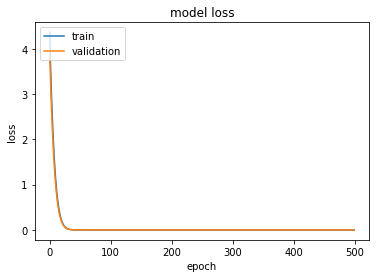

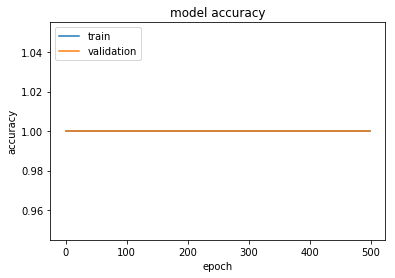

In [854]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [855]:
sum = 0.0
for val in history.history['acc']:
    sum+=val
avg = sum/epochs
print("Average Training Accuracy: ", avg)


sum = 0.0
for val in history.history['val_acc']:
    sum+=val
avg = sum/epochs
print("Average Validation Accuracy: ", avg)

print("Last Training Accuracy: ", history.history['acc'][epochs-1])
print("Last Validation Accuracy: ", history.history['val_acc'][epochs-1])


sum = 0.0
for i in range (epochs-10, epochs):
    sum+= history.history['val_acc'][i]
avg = sum / 10.0
print("Average of last 10 validation Accuracies: ", avg)

Average Training Accuracy:  1.0
Average Validation Accuracy:  1.0
Last Training Accuracy:  1.0
Last Validation Accuracy:  1.0
Average of last 10 validation Accuracies:  1.0


In [856]:
clf = RandomForestClassifier(n_jobs = 10, n_estimators = 100, max_features = num_features, max_depth = 15, 
                             min_samples_split = 100, min_samples_leaf = 30, min_weight_fraction_leaf = 0., 
                            max_leaf_nodes = 50, min_impurity_decrease = 0.001, bootstrap = True, 
                            oob_score = False, verbose = 0, criterion = "gini")
clf.fit(x_train, y_train)
predicted = clf.predict(x_val)
correct = 0
for i in range(0, len(predicted)):
    if (y_val[i][0] == predicted[i][0]):
        if (y_val[i][1] == predicted[i][1]):
            #if (y_val[i][2] == predicted[i][2]):
                correct+=1
print(correct / len(predicted))
print(correct)


1.0
274
